<a href="https://colab.research.google.com/github/Nckflannery/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

## Import

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 19.30 MiB | 22.69 MiB/s, done.
Resolving deltas: 100% (71/71), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 92kB 3.1MB/s 
     |████████████████████████████████| 112kB 8.7MB/s 
     |████████████████████████████████| 133kB 52.2MB/s 
     |████████████████████████████████| 57.7MB 1.4MB/s 
     |████████████████████████████████| 235kB 42.0MB/s 
     |████████████████████████████████| 614kB 47.3MB/s 
     |████████████████████████████████| 235kB 49.6MB/s 
     |████████████████████████████████| 307kB 52.4MB/s 
     |████████████████████████████████| 51kB 25.6MB/s 
     |████████████████████████████████| 215kB 58.7MB/s 
     |██████████

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [7]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [8]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

##Assignment

## First some data cleaning/feature engineering

In [0]:
# Let's start by copying to keep our original df intact
df1 = df.copy()

In [306]:
df1.dtypes

BOROUGH                             object
NEIGHBORHOOD                        object
BUILDING_CLASS_CATEGORY             object
TAX_CLASS_AT_PRESENT                object
BLOCK                                int64
LOT                                  int64
ADDRESS                             object
ZIP_CODE                           float64
RESIDENTIAL_UNITS                  float64
COMMERCIAL_UNITS                   float64
TOTAL_UNITS                        float64
GROSS_SQUARE_FEET                  float64
YEAR_BUILT                         float64
TAX_CLASS_AT_TIME_OF_SALE            int64
BUILDING_CLASS_AT_TIME_OF_SALE      object
SALE_PRICE                           int64
SALE_DATE                           object
SIZE                              category
dtype: object

In [212]:
df1.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [0]:
# We'll drop the EASE-MENT column since it is completely blank and the 
# APARTMENT_NUMBER because it is mostly NaN's and because it probably doesn't
# have that much to do with the sale_price anyways...
df1 = df1.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis=1) 

In [214]:
# Let's look at the non numeric columns
df1.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,23040,23040,23040,23039,23039,23040,22987,23040,23040
unique,5,11,44,10,146,22691,3652,147,120
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,D4,100 JEROME STREET,0,D4,01/24/2019
freq,7494,19117,5061,11071,3408,6,7500,3408,480


####LAND_SQUARE_FEET convert

In [215]:
df1['LAND_SQUARE_FEET'].head()

0    10,733
1     2,962
2     2,074
3         0
4         0
Name: LAND_SQUARE_FEET, dtype: object

In [216]:
# I want to include this data so I will bin it into a new column with a 0-9 
# rating for how many square feet a property is
## First though, we will need to clean the data a little since we have NaN's and
## commas and we will convert it to ints
df1['LAND_SQUARE_FEET'] = df1['LAND_SQUARE_FEET'].fillna(0)
df1['LAND_SQUARE_FEET'] = df1['LAND_SQUARE_FEET'].str.replace(',','')
df1['LAND_SQUARE_FEET'] = df1['LAND_SQUARE_FEET'].astype(int)

ValueError: ignored

In [0]:
### WHHHATTTTT, let's look closer
# let's also make our life easier
lsf = 'LAND_SQUARE_FEET'
df1[lsf] = df1[lsf].fillna('0')

In [0]:
df1[lsf] = df1[lsf].str.replace(',', '')

In [239]:
df1[lsf] = df1[lsf].astype(int)

ValueError: ignored

In [241]:
# Why would someone do that...
df1[df1[lsf]=='########']

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18508,2,OTHER,33 EDUCATIONAL FACILITIES,4,5958,1,W6,6301 RIVERDALE AVENUE,10471.0,0.0,1.0,1.0,########,237021.0,1848.0,4,W6,1,04/02/2019


In [0]:
df1[lsf] = df1[lsf].replace('########', '0')

In [0]:
df1[lsf] = df1[lsf].astype(int)

In [245]:
df1[lsf].head()

0    10733
1     2962
2     2074
3        0
4        0
Name: LAND_SQUARE_FEET, dtype: int64

In [246]:
min(df1[lsf]), max(df1[lsf])

(0, 970000)

In [0]:
# Let's bin it to a new feature. Since the new feature would be categorical, 
# I will use label parameter to give them int values instead
bins = [0, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 50000, 9999999]
df1['SIZE'] = pd.cut(df1[lsf], bins=bins, labels=[0,1,2,3,4,5,6,7,8,9], 
                     include_lowest=True)

In [249]:
df1['SIZE'].value_counts()

0    14857
1     5183
2      937
4      413
3      407
9      388
6      307
5      257
8      207
7       84
Name: SIZE, dtype: int64

In [311]:
df1['SIZE'].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ordered=True)

In [0]:
df1['SIZE'] = df1['SIZE'].astype(int)

In [313]:
df1['SIZE'].dtype

dtype('int64')

In [0]:
# Let's drop the LAND_SQUARE_FEET feature before one-hot so we don't end up with
# thousands of columns
df1 = df1.drop(lsf, axis=1)

In [251]:
df1.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,SIZE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",10011.0,1.0,0.0,1.0,1979.0,2007.0,2,R4,0,01/01/2019,4
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,10018.0,0.0,6.0,6.0,15435.0,1920.0,4,O5,0,01/01/2019,1
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,10018.0,0.0,7.0,7.0,11332.0,1930.0,4,O5,0,01/01/2019,0
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,500.0,0.0,2,R4,0,01/01/2019,0
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,6406.0,0.0,2,R1,0,01/01/2019,0


###Continued data cleaning

In [259]:
df1['TAX_CLASS_AT_PRESENT'].value_counts(), df1['TAX_CLASS_AT_PRESENT'].dtype

(1     11071
 2      8189
 4      1580
 2A      704
 2C      590
 1A      371
 1B      280
 2B      161
 1C       47
 1D       46
 Name: TAX_CLASS_AT_PRESENT, dtype: int64, dtype('O'))

In [0]:
df1['TAX_CLASS_AT_PRESENT'] = df1['TAX_CLASS_AT_PRESENT'].fillna('1')

In [261]:
df1['TAX_CLASS_AT_PRESENT'].value_counts()

1     11072
2      8189
4      1580
2A      704
2C      590
1A      371
1B      280
2B      161
1C       47
1D       46
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [275]:
print((df1[df1['BUILDING_CLASS_AT_PRESENT'] != df1['BUILDING_CLASS_AT_TIME_OF_SALE']]).shape)
print(df1.shape)
print(60/23040)
# Less than 1 percent of the data in these two columns is different...let's just
# drop one. Since building class present has an NaN value....
df1 = df1.drop('BUILDING_CLASS_AT_PRESENT', axis=1)

(60, 19)
(23040, 19)
0.0026041666666666665


In [276]:
df1.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,SIZE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,"447 WEST 18TH STREET, PH12A",10011.0,1.0,0.0,1.0,1979.0,2007.0,2,R4,0,01/01/2019,4
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,144 WEST 37TH STREET,10018.0,0.0,6.0,6.0,15435.0,1920.0,4,O5,0,01/01/2019,1
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,40 WEST 38TH STREET,10018.0,0.0,7.0,7.0,11332.0,1930.0,4,O5,0,01/01/2019,0
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,500.0,0.0,2,R4,0,01/01/2019,0
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,6406.0,0.0,2,R1,0,01/01/2019,0


In [281]:
# This one line has a lot of NaN's
df1[df1['ZIP_CODE'].isnull()]

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,SIZE
22943,3,BOROUGH PARK,37 RELIGIOUS FACILITIES,1,5739,2,N/A 13TH AVENUE,NaN,NaN,NaN,NaN,NaN,NaN,4,M4,17500000,04/30/2019,0


In [0]:
df1 = df1.drop(22943)

In [0]:
df1.isnull().sum()

In [0]:
df1['YEAR_BUILT'] = df1['YEAR_BUILT'].fillna(0)

In [309]:
df1.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
SIZE                              0
dtype: int64

In [314]:
df1.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,23039,23039,23039,23039,23039,23039,23039
unique,5,11,44,10,22691,146,120
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,100 JEROME STREET,D4,01/24/2019
freq,7494,19117,5061,11071,6,3408,480


In [0]:
# We don't want to use the address, but we'll have room to encode the rest
df1 = df1.drop('ADDRESS', axis=1)

In [0]:
df1 = df1[(df1['SALE_PRICE']>100000) & (df1['SALE_PRICE']<2000000)]

## Train/test split

In [590]:
df1.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE', 'SIZE'],
      dtype='object')

In [591]:
# Want to filter by SALE_DATE
min(df1['SALE_DATE']), max(df1['SALE_DATE']), df1['SALE_DATE'].dtype

('01/01/2019', '04/30/2019', dtype('O'))

In [0]:
# No need to convert to date time!
split = '04-01-2019'
train = df1[df1['SALE_DATE'] < split]
test = df1[df1['SALE_DATE'] >= split]

In [0]:
X_train = train.drop(['SALE_DATE', 'SALE_PRICE'], axis=1)
X_test = test.drop(['SALE_DATE', 'SALE_PRICE'], axis=1)

y_train = train['SALE_PRICE']
y_test = test['SALE_PRICE']

In [594]:
X_train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SIZE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9,2
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1,1
66,1,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,10022.0,0.0,0.0,0.0,0.0,1960.0,2,D4,0
67,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,10075.0,0.0,0.0,0.0,0.0,1925.0,2,D4,0
71,1,UPPER WEST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1171,2200,10069.0,1.0,0.0,1.0,827.0,2004.0,2,R4,0


In [595]:
X_test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SIZE
18167,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,695,1562,10011.0,1.0,0.0,1.0,670.0,2005.0,2,R4,0
18170,1,OTHER,17 CONDO COOPS,2,721,1008,10011.0,0.0,0.0,0.0,0.0,1932.0,2,R9,0
18173,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,31,1050,10005.0,1.0,0.0,1.0,438.0,1987.0,2,R4,0
18174,1,GRAMERCY,10 COOPS - ELEVATOR APARTMENTS,2,880,42,10010.0,0.0,0.0,0.0,0.0,1964.0,2,D4,0
18175,1,GRAMERCY,13 CONDOS - ELEVATOR APARTMENTS,2,878,1010,10010.0,1.0,0.0,1.0,773.0,1952.0,2,R4,6


## One-hot encoding

In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [597]:
X_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_1,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_FOREST HILLS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING_CLASS_CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_44 CONDO PARKING,BUILDING_CLASS_CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING_CLASS_CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING_CLASS_CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING_CLASS_CATEGORY_17 CONDO COOPS,BUILDING_CLASS_CATEGORY_29 COMMERCIAL GARAGES,BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING_CLASS_CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_27 FACTORIES,BUILDING_CLASS_CATEGORY_22 STORE BUILDINGS,BUILDING_CLASS_CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING_CLASS_CATEGORY_45 CONDO HOTELS,BUILDING_CLASS_CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING_CLASS_CATEGORY_14 RENTALS - 4-10 UNIT,...,BUILDING_CLASS_AT_TIME_OF_SALE_C9,BUILDING_CLASS_AT_TIME_OF_SALE_F1,BUILDING_CLASS_AT_TIME_OF_SALE_W9,BUILDING_CLASS_AT_TIME_OF_SALE_G1,BUILDING_CLASS_AT_TIME_OF_SALE_S5,BUILDING_CLASS_AT_TIME_OF_SALE_O2,BUILDING_CLASS_AT_TIME_OF_SALE_E1,BUILDING_CLASS_AT_TIME_OF_SALE_C7,BUILDING_CLASS_AT_TIME_OF_SALE_O5,BUILDING_CLASS_AT_TIME_OF_SALE_M9,BUILDING_CLASS_AT_TIME_OF_SALE_RR,BUILDING_CLASS_AT_TIME_OF_SALE_Q9,BUILDING_CLASS_AT_TIME_OF_SALE_G3,BUILDING_CLASS_AT_TIME_OF_SALE_W2,BUILDING_CLASS_AT_TIME_OF_SALE_F4,BUILDING_CLASS_AT_TIME_OF_SALE_O8,BUILDING_CLASS_AT_TIME_OF_SALE_J9,BUILDING_CLASS_AT_TIME_OF_SALE_R7,BUILDING_CLASS_AT_TIME_OF_SALE_W8,BUILDING_CLASS_AT_TIME_OF_SALE_S0,BUILDING_CLASS_AT_TIME_OF_SALE_F9,BUILDING_CLASS_AT_TIME_OF_SALE_R8,BUILDING_CLASS_AT_TIME_OF_SALE_D9,BUILDING_CLASS_AT_TIME_OF_SALE_O1,BUILDING_CLASS_AT_TIME_OF_SALE_H7,BUILDING_CLASS_AT_TIME_OF_SALE_R5,BUILDING_CLASS_AT_TIME_OF_SALE_O9,BUILDING_CLASS_AT_TIME_OF_SALE_P2,BUILDING_CLASS_AT_TIME_OF_SALE_V3,BUILDING_CLASS_AT_TIME_OF_SALE_E9,BUILDING_CLASS_AT_TIME_OF_SALE_T2,BUILDING_CLASS_AT_TIME_OF_SALE_RA,BUILDING_CLASS_AT_TIME_OF_SALE_L9,BUILDING_CLASS_AT_TIME_OF_SALE_V2,BUILDING_CLASS_AT_TIME_OF_SALE_O4,BUILDING_CLASS_AT_TIME_OF_SALE_K9,BUILDING_CLASS_AT_TIME_OF_SALE_W3,BUILDING_CLASS_AT_TIME_OF_SALE_I5,BUILDING_CLASS_AT_TIME_OF_SALE_J1,SIZE
44,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
61,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
66,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [598]:
X_test.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_1,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_FOREST HILLS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING_CLASS_CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_44 CONDO PARKING,BUILDING_CLASS_CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING_CLASS_CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING_CLASS_CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING_CLASS_CATEGORY_17 CONDO COOPS,BUILDING_CLASS_CATEGORY_29 COMMERCIAL GARAGES,BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING_CLASS_CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_27 FACTORIES,BUILDING_CLASS_CATEGORY_22 STORE BUILDINGS,BUILDING_CLASS_CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING_CLASS_CATEGORY_45 CONDO HOTELS,BUILDING_CLASS_CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING_CLASS_CATEGORY_14 RENTALS - 4-10 UNIT,...,BUILDING_CLASS_AT_TIME_OF_SALE_C9,BUILDING_CLASS_AT_TIME_OF_SALE_F1,BUILDING_CLASS_AT_TIME_OF_SALE_W9,BUILDING_CLASS_AT_TIME_OF_SALE_G1,BUILDING_CLASS_AT_TIME_OF_SALE_S5,BUILDING_CLASS_AT_TIME_OF_SALE_O2,BUILDING_CLASS_AT_TIME_OF_SALE_E1,BUILDING_CLASS_AT_TIME_OF_SALE_C7,BUILDING_CLASS_AT_TIME_OF_SALE_O5,BUILDING_CLASS_AT_TIME_OF_SALE_M9,BUILDING_CLASS_AT_TIME_OF_SALE_RR,BUILDING_CLASS_AT_TIME_OF_SALE_Q9,BUILDING_CLASS_AT_TIME_OF_SALE_G3,BUILDING_CLASS_AT_TIME_OF_SALE_W2,BUILDING_CLASS_AT_TIME_OF_SALE_F4,BUILDING_CLASS_AT_TIME_OF_SALE_O8,BUILDING_CLASS_AT_TIME_OF_SALE_J9,BUILDING_CLASS_AT_TIME_OF_SALE_R7,BUILDING_CLASS_AT_TIME_OF_SALE_W8,BUILDING_CLASS_AT_TIME_OF_SALE_S0,BUILDING_CLASS_AT_TIME_OF_SALE_F9,BUILDING_CLASS_AT_TIME_OF_SALE_R8,BUILDING_CLASS_AT_TIME_OF_SALE_D9,BUILDING_CLASS_AT_TIME_OF_SALE_O1,BUILDING_CLASS_AT_TIME_OF_SALE_H7,BUILDING_CLASS_AT_TIME_OF_SALE_R5,BUILDING_CLASS_AT_TIME_OF_SALE_O9,BUILDING_CLASS_AT_TIME_OF_SALE_P2,BUILDING_CLASS_AT_TIME_OF_SALE_V3,BUILDING_CLASS_AT_TIME_OF_SALE_E9,BUILDING_CLASS_AT_TIME_OF_SALE_T2,BUILDING_CLASS_AT_TIME_OF_SALE_RA,BUILDING_CLASS_AT_TIME_OF_SALE_L9,BUILDING_CLASS_AT_TIME_OF_SALE_V2,BUILDING_CLASS_AT_TIME_OF_SALE_O4,BUILDING_CLASS_AT_TIME_OF_SALE_K9,BUILDING_CLASS_AT_TIME_OF_SALE_W3,BUILDING_CLASS_AT_TIME_OF_SALE_I5,BUILDING_CLASS_AT_TIME_OF_SALE_J1,SIZE
18167,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18170,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18173,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18174,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18175,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6


## Feature selection with SelectKBest

In [652]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
cool = []
for k in range(1, len(X_train.columns)+1):
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    cool.append(mae)

print(f'You should use {cool.index(min(cool))} features')

You should use 105 features


In [667]:
selector = SelectKBest(score_func=f_regression, k=105)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((10442, 105), (2969, 105))

In [668]:
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
    
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.02f}')
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: ${train_rmse:.02f}')
test_r2 = r2_score(y_test, y_pred)
print(f'Test R^2: {test_r2:.05f}')

Test MAE: $236,063.98
Test RMSE: $306840.67
Test R^2: 0.41172


## Feature scaling

In [0]:
from sklearn import preprocessing

In [0]:
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

In [670]:
X_train_scaled

array([[ 1.66260018, -0.72660064, -0.46249729, ..., -0.00978653,
        -0.00978653,  0.8372718 ],
       [-0.60146752,  1.37627184, -0.46249729, ..., -0.00978653,
        -0.00978653,  0.20547587],
       [-0.60146752, -0.72660064,  2.16217483, ..., -0.00978653,
        -0.00978653, -0.42632007],
       ...,
       [-0.60146752, -0.72660064, -0.46249729, ..., -0.00978653,
        -0.00978653,  0.20547587],
       [-0.60146752, -0.72660064, -0.46249729, ..., -0.00978653,
        -0.00978653,  0.8372718 ],
       [-0.60146752,  1.37627184, -0.46249729, ..., -0.00978653,
        -0.00978653,  0.20547587]])

## Ridge regression

In [674]:
  from sklearn.metrics import r2_score
  import numpy as np
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  
  # print(f'For {feature} to {target} with testsize {testsize:.2f}')
  
  train_mae = mean_absolute_error(y_train, y_train_pred)
  print(f'Training MAE: ${train_mae:,.02f}')
  
  train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
  print(f'Train RMSE: ${train_rmse:,.02f}')
  
  train_r2 = r2_score(y_train, y_train_pred)
  print(f'Train R^2: {train_r2:.05f}')
  
  test_mae = mean_absolute_error(y_test, y_test_pred)
  print(f'Test MAE: ${test_mae:,.02f}')
  
  test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
  print(f'Test RMSE: ${test_rmse:,.02f}')
  
  test_r2 = r2_score(y_test, y_test_pred)
  print(f'Test R^2: {test_r2:.05f}')

Training MAE: $227,576.06
Train RMSE: $306,840.67
Train R^2: 0.41736
Test MAE: $489,210,924.00
Test RMSE: $10,713,076,839.21
Test R^2: -644663552.58733


In [675]:
ridge_reg = Ridge().fit(X_train, y_train)
ridge_train_pred = ridge_reg.predict(X_train)
ridge_test_pred = ridge_reg.predict(X_test)

  
test_mae = mean_absolute_error(y_test, ridge_test_pred)
print(f'Ridge Test MAE: ${test_mae:,.02f}')
  
test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_pred))
print(f'Ridge Test RMSE: ${test_rmse:,.02f}')
  
test_r2 = r2_score(y_test, ridge_test_pred)
print(f'Ridge Test R^2: {test_r2:.05f}')

Ridge Test MAE: $236,344.27
Ridge Test RMSE: $323,808.81
Ridge Test R^2: 0.41105


In [677]:
# What about scaled
ridge_reg = Ridge(alpha=20).fit(X_train_scaled, y_train)
ridge_train_pred = ridge_reg.predict(X_train_scaled)
ridge_test_pred = ridge_reg.predict(X_test_scaled)

  
test_mae = mean_absolute_error(y_test, ridge_test_pred)
print(f'Ridge Test MAE: ${test_mae:,.02f}')
  
test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_pred))
print(f'Ridge Test RMSE: ${test_rmse:,.02f}')
  
test_r2 = r2_score(y_test, ridge_test_pred)
print(f'Ridge Test R^2: {test_r2:.04f}')

Ridge Test MAE: $239,683.79
Ridge Test RMSE: $329,137.64
Ridge Test R^2: 0.3915


In [679]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_test_pred)
print(f'Test MAE: ${test_mae:,.02f}')

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test RMSE: ${test_rmse:,.02f}')
  
test_r2 = r2_score(y_test, y_test_pred)
print(f'Test R^2: {test_r2:.05f}')

Test MAE: $707,929,185,259,190,912.00
Test RMSE: $3,264,394,953,988,788,736.00
Test R^2: -59856328423919444081770496.00000


In [0]:
#bad

In [614]:
alphas = []
maes = []

for alpha in range(1, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train_scaled, y_train)
    mae = mean_absolute_error(y_test, ridge_reg_split.predict(X_test_scaled))
    print(f'{alpha}, {mae}')
    alphas.append(alpha)
    maes.append(mae)

1, 239651.9341443868
2, 239661.7972298241
3, 239668.25594137958
4, 239674.46931366998
5, 239682.26981713335
6, 239687.6556653404
7, 239691.11613315716
8, 239693.17995238633
9, 239694.23905715247
10, 239694.55901047098
11, 239695.10162243564
12, 239695.47576370867
13, 239695.2288685381
14, 239694.46895038508
15, 239693.31960695892
16, 239691.82766926105
17, 239690.15775516783
18, 239688.26043725628
19, 239686.13333434932
20, 239683.78776205552
21, 239681.2516846351
22, 239678.54867465948
23, 239675.69873968538
24, 239672.71896904212
25, 239669.62404479994
26, 239666.42664906327
27, 239663.13779133055
28, 239659.77181228736
29, 239656.34025685058
30, 239652.84334364333
31, 239649.32205437394
32, 239645.7470477367
33, 239642.12346138188
34, 239638.4636025816
35, 239634.76869888895
36, 239631.0373360084
37, 239627.27283548345
38, 239623.4781914792
39, 239619.65610938283
40, 239615.80903908578
41, 239612.05745061068
42, 239608.56845419886
43, 239605.10142143164
44, 239601.66237307672
45, 23

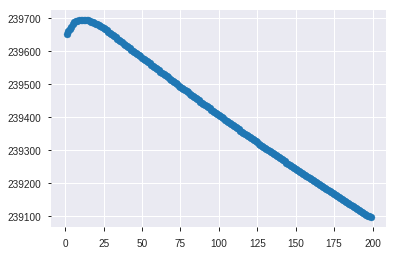

In [615]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, maes);

# Some other stuff I want to try out

In [535]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,SIZE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,10011.0,1.0,0.0,1.0,1979.0,2007.0,2,R4,0,01/01/2019,4
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,10018.0,0.0,6.0,6.0,15435.0,1920.0,4,O5,0,01/01/2019,1
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,10018.0,0.0,7.0,7.0,11332.0,1930.0,4,O5,0,01/01/2019,0
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,10014.0,1.0,0.0,1.0,500.0,0.0,2,R4,0,01/01/2019,0
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,10065.0,1.0,0.0,1.0,6406.0,0.0,2,R1,0,01/01/2019,0


In [536]:
test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,SIZE
18167,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,695,1562,10011.0,1.0,0.0,1.0,670.0,2005.0,2,R4,949000,04/01/2019,0
18168,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,767,1609,10011.0,1.0,0.0,13.0,36835.0,1912.0,2,R4,4683950,04/01/2019,2
18169,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,767,1612,10011.0,1.0,0.0,13.0,36835.0,1912.0,2,R4,5600000,04/01/2019,2
18170,1,OTHER,17 CONDO COOPS,2,721,1008,10011.0,0.0,0.0,0.0,0.0,1932.0,2,R9,1100000,04/01/2019,0
18171,1,OTHER,21 OFFICE BUILDINGS,4,746,64,10011.0,3.0,1.0,4.0,5603.0,1900.0,4,O8,0,04/01/2019,0


In [0]:
train_no_price = train.drop('SALE_PRICE', axis=1)
all_features = train_no_price.select_dtypes(include='number').columns

In [0]:
features = ['SIZE', 'GROSS_SQUARE_FEET', 'ZIP_CODE']
target = 'SALE_PRICE'

In [0]:
from sklearn.model_selection import train_test_split
def my_lin_test(data, feature, target, testsize=.2):
  X_train, X_test, y_train, y_test = train_test_split(data[feature], 
                                                      data[target], 
                                                      test_size=testsize,
                                                      random_state=42)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  
  print(f'For {feature} to {target} with testsize {testsize:.2f}')
  
  train_mae = mean_absolute_error(y_train, y_train_pred)
  print(f'Training MAE: {train_mae:.05f}')
  
  train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
  print(f'Train RMSE: {train_rmse:.05f}')
  
  train_r2 = r2_score(y_train, y_train_pred)
  print(f'Train R^2: {train_r2:.05f}')
  
  
  test_mae = mean_absolute_error(y_test, y_test_pred)
  print(f'Test MAE: {test_mae:.05f}')
  
  test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
  print(f'Test RMSE: {test_rmse:.05f}')
  
  test_r2 = r2_score(y_test, y_test_pred)
  print(f'Test R^2: {test_r2:.05f}')

In [557]:
my_lin_test(df1, features, target)

For ['SIZE', 'GROSS_SQUARE_FEET', 'ZIP_CODE'] to SALE_PRICE with testsize 0.20
Training MAE: 1454559.06626
Train RMSE: 7893745.69019
Train R^2: 0.24932
Test MAE: 1580709.94802
Test RMSE: 12548899.81486
Test R^2: 0.18670


In [558]:
my_lin_test(df1, all_features, target)

For Index(['BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SIZE'],
      dtype='object') to SALE_PRICE with testsize 0.20
Training MAE: 1479195.30357
Train RMSE: 7727751.82877
Train R^2: 0.28056
Test MAE: 1601054.90860
Test RMSE: 12436572.26511
Test R^2: 0.20120


In [0]:
def my_ridge(data, feature, target, alpha=0, testsize=.2):
  X_train, X_test, y_train, y_test = train_test_split(data[feature], 
                                                      data[target], 
                                                      test_size=testsize,
                                                      random_state=42)
  
  X_train_scaled = preprocessing.scale(X_train)
  X_test_scaled = preprocessing.scale(X_test)
  
  ridge_reg = Ridge(alpha=alpha)
  ridge_reg.fit(X_train_scaled, y_train)
  y_train_pred = ridge_reg.predict(X_train_scaled)
  y_test_pred = ridge_reg.predict(X_test_scaled)
  
  print(f'For {feature} to {target} with testsize {testsize:.2f}')
  
  train_mae = mean_absolute_error(y_train, y_train_pred)
  print(f'Training MAE: ${train_mae:,.02f}')
  
  train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
  print(f'Train RMSE: ${train_rmse:,.02f}')
  
  train_r2 = r2_score(y_train, y_train_pred)
  print(f'Train R^2: {train_r2:.05f}')
  
  
  test_mae = mean_absolute_error(y_test, y_test_pred)
  print(f'Test MAE: ${test_mae:,.02f}')
  
  test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
  print(f'Test RMSE: ${test_rmse:,.02f}')
  
  test_r2 = r2_score(y_test, y_test_pred)
  print(f'Test R^2: {test_r2:.05f}')

In [680]:
my_ridge(df1, feature, target)

For ['SIZE', 'GROSS_SQUARE_FEET', 'ZIP_CODE'] to SALE_PRICE with testsize 0.20
Training MAE: $316,042.29
Train RMSE: $402,353.65
Train R^2: 0.01362
Test MAE: $321,316.59
Test RMSE: $411,355.47
Test R^2: 0.00893


In [682]:
my_ridge(df1, feature, target, alpha=2000)

For ['SIZE', 'GROSS_SQUARE_FEET', 'ZIP_CODE'] to SALE_PRICE with testsize 0.20
Training MAE: $316,212.04
Train RMSE: $402,411.70
Train R^2: 0.01334
Test MAE: $321,384.30
Test RMSE: $411,345.74
Test R^2: 0.00898


In [683]:
my_ridge(df1, feature, target, testsize=.1)

For ['SIZE', 'GROSS_SQUARE_FEET', 'ZIP_CODE'] to SALE_PRICE with testsize 0.10
Training MAE: $316,106.90
Train RMSE: $401,922.44
Train R^2: 0.01293
Test MAE: $328,679.39
Test RMSE: $423,905.30
Test R^2: 0.01071


In [684]:
my_ridge(df1, all_features, target)

For Index(['BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SIZE'],
      dtype='object') to SALE_PRICE with testsize 0.20
Training MAE: $304,589.15
Train RMSE: $388,451.73
Train R^2: 0.08061
Test MAE: $305,024.47
Test RMSE: $392,573.87
Test R^2: 0.09737


In [685]:
my_ridge(df1, all_features, target, testsize=1/3)

For Index(['BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SIZE'],
      dtype='object') to SALE_PRICE with testsize 0.33
Training MAE: $304,923.02
Train RMSE: $388,122.93
Train R^2: 0.08080
Test MAE: $304,625.63
Test RMSE: $391,286.57
Test R^2: 0.09224
